# Performance Comparisons

We want to compare against several other packages on standard problems:

* GUDHI
* Dionysus
* Ripser
* TopologyLayer
* BATS standard with and without basis formation
* BATS clearing/compression optimizations (no basis)

Note TopologyLayer requires pytorch 1.1
```
conda install pytorch=1.1 -c pytorch
```

Dionysus and Gudhi can be installed via pip
```
pip install dionyusus gudhi
```

Write wrapper functions.  Take as input either two images or two metric spaces

In [1]:
import bats
import numpy as np
import matplotlib.pyplot as plt
import time
from freudenthal import freudenthal_grid
import gudhi as gd
import dionysus as d

# Levelset Comparison

In [2]:
m = 200
n = 200

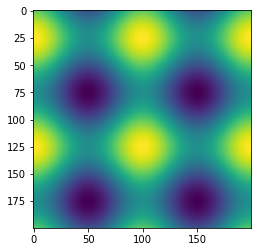

In [3]:
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

f2 = f + 0.01*np.random.randn(m,n)
plt.imshow(f);

### BATS update:

In [4]:
def time_BATS_update(img, img2):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    t1 = time.monotonic()
    print("time to extend: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.FilteredSimplicialComplex(X, vals)
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img2.flatten())
    R.update_filtration(vals)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
time_BATS_update(f, f2)

time to extend: 0.03792161800083704 sec.
time to construct: 0.0694179699930828 sec.
time to reduce: 1.026343823003117 sec.
time to update: 0.1731625719985459 sec.


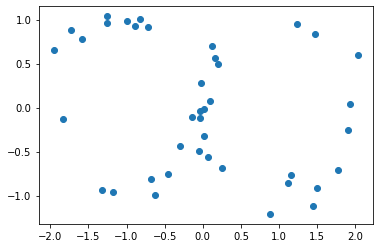

In [5]:
# first, generate two noisy circles
n = 40
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:20,0] = Y[:20,0] - 1
Y[20:,0] = Y[20:,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.01*np.random.randn(n,2)

In [6]:
def time_BATS_update_rips(X, Y):
    dist = bats.Euclidean()  # distance we would like to use
    
    data = bats.DataSet(bats.Matrix(X)) # put into a bats.DataSet
    data_Y = bats.DataSet(bats.Matrix(Y)) # put into a bats.DataSet
    
    t0 = time.monotonic()
    F_X = bats.RipsFiltration(data, dist, np.inf, 2) # generate a RipsFiltration
    t1 = time.monotonic()
    print("time to construct: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R_X = bats.reduce(F_X, bats.F2()) # reduce with F2 coefficients
    t1 = time.monotonic()
    print("time to reduce: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F_Y = bats.RipsFiltration(data_Y, dist, np.inf, 2) # generate a RipsFiltration
    UI = bats.UpdateInfoFiltration(F_X, F_Y)
    R_X.update_filtration_general(UI)
    t1 = time.monotonic()
    print("time to update: {} sec.".format(t1 - t0))
    
time_BATS_update_rips(Y, Y2)

time to construct: 0.008016264997422695 sec.
time to reduce: 0.015545542992185801 sec.
time to update: 0.02480579898110591 sec.


### BATS with flags

In [7]:
def time_BATS_flags(img, img2, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    m, n = img.shape
    X = freudenthal_grid(m, n)
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    vals, imap = bats.lower_star_filtration(X, img2.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
    
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis",
    "standard w/ no basis",
    "standard w/ clearing",
    "standard w/ compression",
    "extra w/ basis",
    "extra w/ no basis",
    "extra w/ clearing",
    "extra w/ compression"
]
for flag, label in zip(flags, labels):
    print("\n{}:".format(label))
    time_BATS_flags(f, f2, flag)



standard w/ basis:
compute1: 0.9379944759712089 sec.
compute2: 1.1418222950014751 sec.

standard w/ no basis:
compute1: 0.2609482010011561 sec.
compute2: 0.49333309999201447 sec.

standard w/ clearing:
compute1: 0.16875154597801156 sec.
compute2: 0.21412920000148006 sec.

standard w/ compression:
compute1: 0.28679490101058036 sec.
compute2: 0.3312042059842497 sec.

extra w/ basis:
compute1: 0.9977845610119402 sec.
compute2: 1.2701111109927297 sec.

extra w/ no basis:
compute1: 0.3719237630139105 sec.
compute2: 0.3586501420068089 sec.

extra w/ clearing:
compute1: 0.1571989190124441 sec.
compute2: 0.24162303199409507 sec.

extra w/ compression:
compute1: 0.3794411380076781 sec.
compute2: 0.43111891398439184 sec.


### TopologyLayer:

In [8]:
from topologylayer.nn import LevelSetLayer2D
from topologylayer.nn import RipsLayer
import torch
import numpy as np
import matplotlib.pyplot as plt
import time

In [9]:
m = 200
n = 200
f = np.empty((m,n))
for i in range(m):
    for j in range(n):
        f[i,j] = np.sin(4*np.pi*i/m) + np.cos(4*np.pi*j/n)

f2 = f + 0.01*np.random.randn(m,n)

In [10]:
def time_toplayer(img, img2):
    
    layer = LevelSetLayer2D(size=img.shape)
    img_t = torch.tensor(img, dtype=torch.float, requires_grad=False)
    img2_t = torch.tensor(img2, dtype=torch.float, requires_grad=False)
    
    t0 = time.monotonic()
    pds = layer(img_t)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    pds = layer(img2_t)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

    
time_toplayer(f, f2)

compute1: 0.4503299260104541 sec.
compute2: 0.4017416060087271 sec.


### GUDHI: see http://gudhi.gforge.inria.fr/python/latest/simplex_tree_ref.html

In [11]:
def construct_gudhi_simplex_tree(img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    GT = gd.SimplexTree()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            GT.insert(s, v)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    return GT

def update_gudhi_simplex_tree(tree, img):
    # create in BATS to dump
    X = freudenthal_grid(*img.shape)
    vals, imap = bats.lower_star_filtration(X, img.flatten())
    F = bats.FilteredSimplicialComplex(X, vals)
    
    t0 = time.monotonic()
    for k in range(F.maxdim() + 1):
        for s, v in zip(X.get_simplices(k), F.vals(k)):
            tree.assign_filtration(s, v)
    t1 = time.monotonic()
    print("update values: {} sec.".format(t1 - t0))
    return tree

def time_gudhi(img, img2):
    GT = construct_gudhi_simplex_tree(img)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    GT = update_gudhi_simplex_tree(GT, img2)
    t0 = time.monotonic()
    diag = GT.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi(f, f2)

construction: 0.2933155109931249 sec.
compute1: 0.12631259200861678 sec.
update values: 0.2930584360146895 sec.
compute2: 0.10875345001113601 sec.


### Dionysus: https://mrzv.org/software/dionysus2/tutorial/lower-star.html

In [12]:
def time_dionysus(img, img2):
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    f_lower_star = d.fill_freudenthal(img2)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f_lower_star)
    dgms = d.init_diagrams(p, f_lower_star)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
time_dionysus(f, f2)

construction: 0.15899596200324595 sec.
persistence: 0.1526442449830938 sec.
construction: 0.22824033800861798 sec.
persistence: 0.1879126130079385 sec.


# Rips Complex

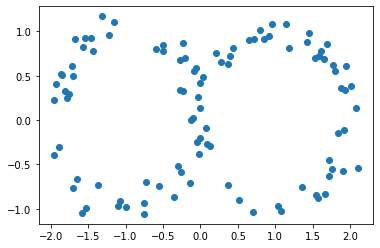

In [13]:
# first, generate two noisy circles
n = 100
Y = np.random.normal(size=(n,2))
Y = Y / np.linalg.norm(Y, axis=1).reshape(-1,1)
Y = Y + np.random.normal(size=(n,2), scale = 0.1 )

Y[:(n//2),0] = Y[:(n//2),0] - 1
Y[(n//2):,0] = Y[(n//2):,0] + 1
fig = plt.scatter(Y[:,0], Y[:,1])

Y2 = Y + 0.01*np.random.randn(n,2)

In [ ]:
# Don't run this for larger problems 
def time_toplayer_rips(y, y2):
    
    # layer = LevelSetLayer2D(size=img.shape)
    layer = RipsLayer(y.shape[0], maxdim=2)
    y_t = torch.tensor(y, dtype=torch.float, requires_grad=False)
    y2_t = torch.tensor(y2, dtype=torch.float, requires_grad=False)
    
    t0 = time.monotonic()
    pds = layer(y_t)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    pds = layer(y2_t)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

    
time_toplayer_rips(Y, Y2)

Compared to TopologyLayer, BATs is much faster!!!! Rips Complex with 40 points in bats is faster than even 20 points in TopologyLayer!

It seems unnecessary for Gudhi to update simplex tree? (Need to write new python bindings for Updating information)

In [14]:
def time_gudhi_rips(X, Y):
    
    t0 = time.monotonic()
    rips_complex = gd.RipsComplex(points=X, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    # need to include setup
    rips_complex = gd.RipsComplex(points=Y, max_edge_length=np.inf)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    diag = simplex_tree.persistence()
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
time_gudhi_rips(Y, Y2)

compute1: 0.09508051001466811 sec.
compute2: 0.09233376698102802 sec.


Gudhi seems to have a good performance. 

In [15]:
def time_dionysus_rips(X, Y):
    
    
    
    t0 = time.monotonic()
    f = d.fill_rips(X, 2, np.inf)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    f = d.fill_rips(Y, 2, np.inf)
    t1 = time.monotonic()
    print("construction: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    p = d.homology_persistence(f)
    dgms = d.init_diagrams(p, f)
    t1 = time.monotonic()
    print("persistence: {} sec.".format(t1 - t0))
    
time_dionysus_rips(Y, Y2)

construction: 0.7478403429850005 sec.
persistence: 0.5551506799820345 sec.
construction: 0.7711001959978603 sec.
persistence: 0.6023649669950828 sec.


## Ripser

In [16]:
from ripser import ripser

In [42]:
?ripser

Rips(maxdim=2, thresh=inf, coeff=2, do_cocycles=False, n_perm = None, verbose=True)


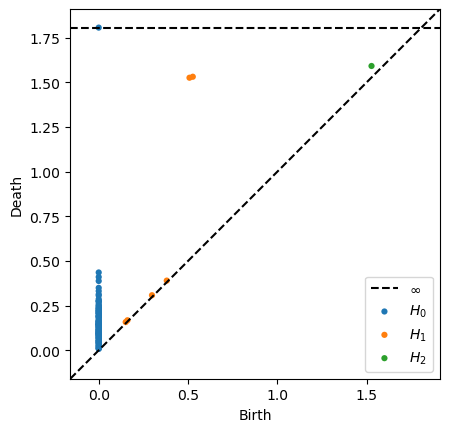

In [27]:
import numpy as np
from ripser import Rips

rips = Rips(maxdim=1)
diagrams = rips.fit_transform(Y)
rips.plot(diagrams)

In [48]:
def time_ripser_rips(X, Y, **kw):
    
    t0 = time.monotonic()
    out = ripser(X, **kw)
    t1 = time.monotonic()
    print("compute1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    out2 = ripser(Y, **kw)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))

print("no basis")
time_ripser_rips(Y, Y2, maxdim=1)

print("with basis")
time_ripser_rips(Y, Y2, do_cocycles=True, maxdim=1)

no basis
compute1: 0.029190789005951956 sec.
compute2: 0.014540612988639623 sec.
with basis
compute1: 0.015163989010034129 sec.
compute2: 0.013484816998243332 sec.


## BATS

In [17]:
import scipy.spatial.distance as distance

def time_BATS_rips(X, Y):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = np.min(np.max(DX, axis=0))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.RipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = np.min(np.max(DY, axis=0))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.RipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2())
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    

time_BATS_rips(Y, Y2)

setup1: 0.0008386929985135794 sec.
construct1: 0.07165698599419557 sec.
reduce1: 0.12075432200799696 sec.
setup2: 0.00044536200584843755 sec.
construct2: 0.06434314700891264 sec.
compute2: 0.14139165700180456 sec.


with flags...

In [20]:
def time_BATS_rips_flags(X, Y, flags=(bats.standard_reduction_flag(), bats.compute_basis_flag())):
    
    t0 = time.monotonic()
    DX = distance.squareform(distance.pdist(X))
    rX = np.min(np.max(DX, axis=0))
    t1 = time.monotonic()
    print("setup1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.RipsFiltration(bats.Matrix(DX), rX, 2)
    t1 = time.monotonic()
    print("construct1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("reduce1: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    DY = distance.squareform(distance.pdist(Y))
    rY = np.min(np.max(DY, axis=0))
    t1 = time.monotonic()
    print("setup2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    F = bats.RipsFiltration(bats.Matrix(DY), rY, 2)
    t1 = time.monotonic()
    print("construct2: {} sec.".format(t1 - t0))
    
    t0 = time.monotonic()
    R = bats.reduce(F, bats.F2(), *flags)
    t1 = time.monotonic()
    print("compute2: {} sec.".format(t1 - t0))
    
    
flags = [
    (bats.standard_reduction_flag(), bats.compute_basis_flag()),
    (bats.standard_reduction_flag(),),
    (bats.standard_reduction_flag(), bats.clearing_flag()),
    (bats.standard_reduction_flag(), bats.compression_flag()),
    (bats.extra_reduction_flag(), bats.compute_basis_flag()),
    (bats.extra_reduction_flag(),),
    (bats.extra_reduction_flag(), bats.clearing_flag()),
    (bats.extra_reduction_flag(), bats.compression_flag()),
]
labels = [
    "standard w/ basis",
    "standard w/ no basis",
    "standard w/ clearing",
    "standard w/ compression",
    "extra w/ basis",
    "extra w/ no basis",
    "extra w/ clearing",
    "extra w/ compression"
]
for flag, label in zip(flags, labels):
    print("\n{}:".format(label))
    time_BATS_rips_flags(Y, Y2, flag)


standard w/ basis:
setup1: 0.0004211979976389557 sec.
construct1: 0.06822383200051263 sec.
reduce1: 0.11914017499657348 sec.
setup2: 0.00038353598210960627 sec.
construct2: 0.06441601499682292 sec.
compute2: 0.1449672860035207 sec.

standard w/ no basis:
setup1: 0.0006250769947655499 sec.
construct1: 0.06224751699483022 sec.
reduce1: 0.06962144700810313 sec.
setup2: 0.00035723598557524383 sec.
construct2: 0.06345965099171735 sec.
compute2: 0.0819992030155845 sec.

standard w/ clearing:
setup1: 0.0011764669907279313 sec.
construct1: 0.08840884198434651 sec.
reduce1: 0.08474524799385108 sec.
setup2: 0.00033836299553513527 sec.
construct2: 0.08657134399982169 sec.
compute2: 0.09662425698479638 sec.

standard w/ compression:
setup1: 0.0004942830128129572 sec.
construct1: 0.059304775000782683 sec.
reduce1: 0.07081191099132411 sec.
setup2: 0.0003853130037896335 sec.
construct2: 0.06676514900755137 sec.
compute2: 0.09182457101996988 sec.

extra w/ basis:
setup1: 0.001121522014727816 sec.
con